# SRGAN Implementation

Jeremy Doan

*Testing applications of trained SRGAN generator*

Image datasets used: 
* https://www.digitalrocksportal.org/projects/305
* 1024 random slices from the dataset were processed in ImageJ to be used for the total dataset

In [1]:
# Import libraries

import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
import cv2 as cv

## Load Generator and Data

In [2]:
# Parameters
ngpu = 1
nc = 3
ngf = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
workers = 0
low_res_size = 32
high_res_size = 128
dataroot = r"C:\Users\johna\Downloads\research\trainingdata"

### Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, ngpu, ngf, nc):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nc, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            ResidualBlock(ngf * 8),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            ResidualBlock(ngf * 4),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            ResidualBlock(ngf * 2),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            ResidualBlock(ngf),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        x = self.main(input)
        return F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.conv(x)
        out = self.bn(out)
        out += identity
        out = self.relu(out)
        return out


In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator(ngpu, ngf, nc).to(device)
netG.load_state_dict(torch.load('sr_generator.pth'))
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(3, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ResidualBlock(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ResidualBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=

### Dataset

In [5]:
# Define the transformations on the data

transform_low = transforms.Compose([
    transforms.Grayscale(num_output_channels=nc),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.Grayscale(num_output_channels=nc),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

In [6]:
class ImageDataset(ImageFolder):
    def __init__(self, root, transform_low, transform_high):
        super().__init__(root=root) 

        # Low res and high res transformations
        self.transform_low = transform_low  
        self.transform_high = transform_high 

    def __getitem__(self, index):

        # Get the image path and label using ImageFolder
        path, _ = self.samples[index]

        # Open the image
        img = Image.open(path).convert("RGB")

        # Apply transformations
        low_res = self.transform_low(img)
        high_res = self.transform_high(img)

        return low_res, high_res


In [7]:
# Create the dataset
dataset = ImageDataset(root=dataroot,
                            transform_low=transform_low,
                            transform_high=transform_high)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)

# Check the shapes of low-res and high-res images
for i, (low_res, high_res) in enumerate(dataloader):
    print(f"Batch {i}: Low-Res Shape: {low_res.shape}, High-Res Shape: {high_res.shape}")
    break

Batch 0: Low-Res Shape: torch.Size([64, 3, 32, 32]), High-Res Shape: torch.Size([64, 3, 128, 128])


## Super Resolution Compared to High-Resolution

We will plot our low-resolution images (32x32 pixels) and our high-resolution images (128x128 pixels) that we created above. We will also feed the low-res images into the SRGAN generator and plot the resulting images alongside the dataset to examine how closely the SRGAN captures the features of the sandstone microstructures.

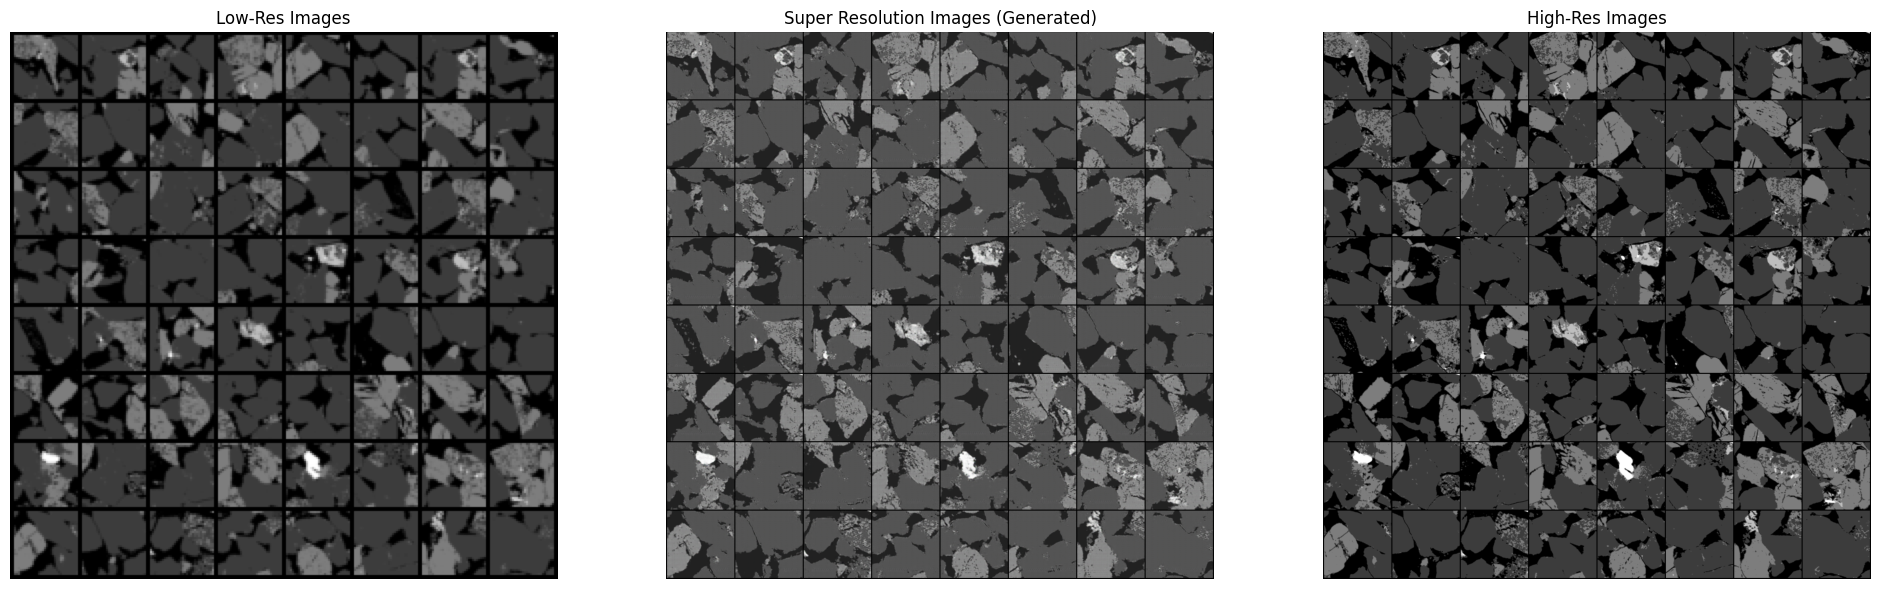

In [8]:
# Visualize low-res, high-res images, and super res images
low_res_batch, high_res_batch = next(iter(dataloader))
low_res_imgs = low_res_batch.to(device)
sr_imgs = netG(low_res_imgs)

# Plot low-res images
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.title("Low-Res Images")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(low_res_batch[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Plot high-res images
plt.subplot(1, 3, 3)
plt.title("High-Res Images")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(high_res_batch[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Plot super res images
plt.subplot(1, 3, 2)
plt.title(f"Super Resolution Images (Generated)")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(sr_imgs[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()


## Retaining High Quality While Zooming In

This allows us to take images with a higher field of view and zoom in to any region.

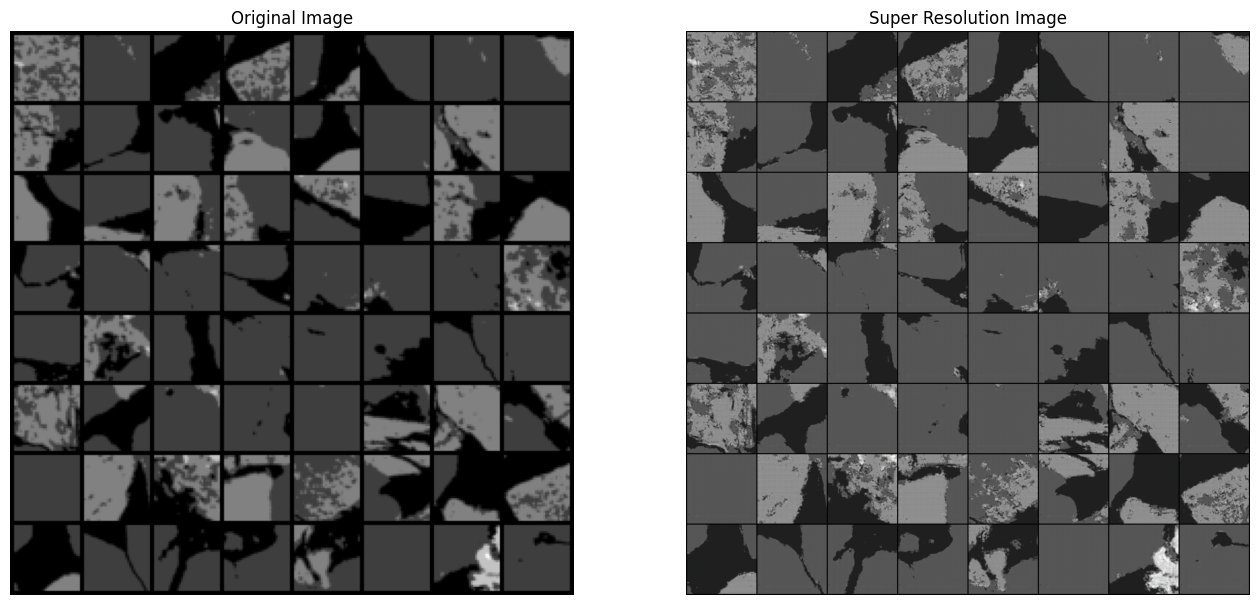

In [9]:
# Create zoomed in images (bottom left corner)
high_res_imgs = high_res_batch.to(device)
crop_im = high_res_imgs[:, :, 0:32, 0:32]
crop_sr = netG(crop_im) 

plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(crop_im[:64], padding=2, normalize=True).cpu(), (1,2,0)))

plt.subplot(1,2,2)
plt.title("Super Resolution Image")
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(crop_sr[:64], padding=2, normalize=True).cpu(), (1,2,0)))

## How well does it work on a random image?

We will use the famous "Sasquatch sighting" image.

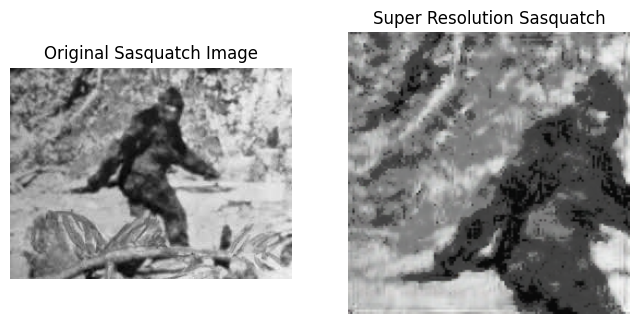

In [50]:
sasquatch = cv.imread(r"C:\Users\johna\Downloads\research\sasquatch.jpg")
x = (259 - 64) // 2
y = (194 - 64) // 2
sasquatch_crop = sasquatch[y-64:y+64, x-64:x+64]
sasquatch_img = cv.cvtColor(sasquatch_crop, cv.COLOR_BGR2RGB)
sasquatch_img = sasquatch_img / 255

sasquatch_img = torch.from_numpy(sasquatch_img).permute(2,0,1).float().unsqueeze(0).to(device)
sasquatch_sr = netG(sasquatch_img)

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Sasquatch Image")
plt.imshow(sasquatch)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Super Resolution Sasquatch")
plt.imshow(np.transpose(vutils.make_grid(sasquatch_sr[:64], padding=2, normalize=True).cpu(), (1,2,0)))

We can observe that the generator struggles to properly increase the resolution of the image since the features do not quite match the microstructure images that the generator was trained on. It is worth noting that the patterns in the SR image somewhat resemble the features in the microstructure images.